In [ ]:
import torch
import random
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import CroppedImageDataset
import torchvision.transforms.functional as F
from FocusNet import FocusNet

import os
from torchvision import transforms

# Load the trained model
model_path = "FocusNet_Madvanced_padding_OSGD_LR0.05_E150.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and load weights
model = FocusNet()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully.")
# Load datasets
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CroppedImageDataset(mode="advanced_padding", split="train", transform=transform)
test_dataset = CroppedImageDataset(mode="advanced_padding", split="test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print("DataLoaders initialized.")

def evaluate_and_display_random_images(model, dataset, num_images=6, save_dir="visualizations"):
    """
    Evaluate and display predictions on random images in a notebook, with proper bounding box visualization.
    Saves the images in the specified folder.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create directory for visualizations if it doesn't exist

    # Randomly select images
    selected_indices = random.sample(range(len(dataset)), num_images)

    # Create a matplotlib grid for displaying the images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, (idx, ax) in enumerate(zip(selected_indices, axes)):
        # Get image and ground-truth bbox
        image, gt_bbox, id = dataset[idx]
        gt_bbox = gt_bbox.numpy()

        # Predict bbox
        image_input = image.unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            pred_bbox = model(image_input).squeeze(0).cpu().numpy()

        # Scale bboxes for 124x124 visualization
        image_size = 124

        def scale_bbox(bbox):
            cx, cy, w, h = bbox
            xmin = (cx - w / 2) * image_size
            ymin = (cy - h / 2) * image_size
            xmax = (cx + w / 2) * image_size
            ymax = (cy + h / 2) * image_size
            return xmin, ymin, xmax, ymax

        gt_xmin, gt_ymin, gt_xmax, gt_ymax = scale_bbox(gt_bbox)
        pred_xmin, pred_ymin, pred_xmax, pred_ymax = scale_bbox(pred_bbox)

        # Convert image tensor to PIL for visualization
        pil_image = F.to_pil_image(image)

        # Create the plot
        ax.imshow(pil_image)
        # Ground truth bbox
        ax.add_patch(plt.Rectangle(
            (gt_xmin, gt_ymin), gt_xmax - gt_xmin, gt_ymax - gt_ymin,
            fill=False, edgecolor='green', linewidth=2, label="Ground Truth"
        ))
        # Predicted bbox
        ax.add_patch(plt.Rectangle(
            (pred_xmin, pred_ymin), pred_xmax - pred_xmin, pred_ymax - pred_ymin,
            fill=False, edgecolor='red', linewidth=2, label="Prediction"
        ))
        ax.set_title(f"Image {i+1}\nGT: {gt_bbox}, Pred: {pred_bbox}")
        ax.axis("off")

        # Save the visualization
        save_path = os.path.join(save_dir, f"image_{i+1}.png")
        plt.savefig(save_path)
        print(f"Saved visualization at {save_path}")

    # Adjust layout and display the grid
    plt.tight_layout()
    plt.show()


In [ ]:
# Evaluate on 6 random images from the train and test datasets
print("Train set:")
evaluate_and_display_random_images(model, train_dataset, num_images=6, save_dir="train_visuals")

print("Test set:")
evaluate_and_display_random_images(model, test_dataset, num_images=6, save_dir="test_visuals")

In [ ]:
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import CroppedImageDataset
import torchvision.transforms.functional as F
from FocusNet import FocusNet
import os
from torchvision import transforms

# Model paths and modes
model_info = [
    {"path": "FocusNet_Mbasic_OSGD_LR0.05_E150.pth", "mode": "basic"},
    {"path": "FocusNet_Mfiltering_OSGD_LR0.05_E150.pth", "mode": "basic"},  # Using mode=basic for filtering test
    {"path": "FocusNet_Mbasic_padding_OSGD_LR0.05_E150.pth", "mode": "basic_padding"},
    {"path": "FocusNet_Madvanced_padding_OSGD_LR0.05_E150.pth", "mode": "advanced_padding"}
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and datasets
models = []
datasets = []

def load_model(model_path):
    model = FocusNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

transform = transforms.Compose([transforms.ToTensor()])

for info in model_info:
    models.append(load_model(info["path"]))
    datasets.append(CroppedImageDataset(mode=info["mode"], split="test", transform=transform))

print("All models and datasets loaded successfully.")

def scale_bbox(bbox, image_size):
    """Scale bounding box for visualization."""
    cx, cy, w, h = bbox
    xmin = (cx - w / 2) * image_size
    ymin = (cy - h / 2) * image_size
    xmax = (cx + w / 2) * image_size
    ymax = (cy + h / 2) * image_size
    return xmin, ymin, xmax, ymax

def evaluate_and_display(models, datasets, num_images=4, save_dir="visualizations"):
    """
    Evaluate and display predictions for all models on the same images.
    Displays results in a 4x4 grid.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create directory for visualizations if it doesn't exist

    # Randomly select images
    selected_indices = random.sample(range(len(datasets[0])), num_images)

    # Create a matplotlib grid for displaying the images
    fig, axes = plt.subplots(num_images, 4, figsize=(20, 15))

    for row_idx, idx in enumerate(selected_indices):
        for col_idx, (model, dataset) in enumerate(zip(models, datasets)):
            # Get image and ground-truth bbox
            image, gt_bbox, _ = dataset[idx]
            gt_bbox = gt_bbox.numpy()

            # Predict bbox
            image_input = image.unsqueeze(0).to(device)  # Add batch dimension
            with torch.no_grad():
                pred_bbox = model(image_input).squeeze(0).cpu().numpy()

            # Scale bboxes for visualization
            image_size = 124
            gt_xmin, gt_ymin, gt_xmax, gt_ymax = scale_bbox(gt_bbox, image_size)
            pred_xmin, pred_ymin, pred_xmax, pred_ymax = scale_bbox(pred_bbox, image_size)

            # Convert image tensor to PIL for visualization
            pil_image = F.to_pil_image(image)

            # Create the plot
            ax = axes[row_idx, col_idx]
            ax.imshow(pil_image)

            # Ground truth bbox
            ax.add_patch(plt.Rectangle(
                (gt_xmin, gt_ymin), gt_xmax - gt_xmin, gt_ymax - gt_ymin,
                fill=False, edgecolor='green', linewidth=2, label="Ground Truth"
            ))

            # Predicted bbox
            ax.add_patch(plt.Rectangle(
                (pred_xmin, pred_ymin), pred_xmax - pred_xmin, pred_ymax - pred_ymin,
                fill=False, edgecolor='red', linewidth=2, label="Prediction"
            ))

            ax.set_title(f"Mode: {model_info[col_idx]['mode']}\nGT: {gt_bbox}\nPred: {pred_bbox}")
            ax.axis("off")

    # Adjust layout and display the grid
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "comparison_grid.png"))
    plt.show()

# Evaluate and display
evaluate_and_display(models, datasets, num_images=4)

/tmp/ipykernel_271641/275955003.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


All models and datasets loaded successfully.


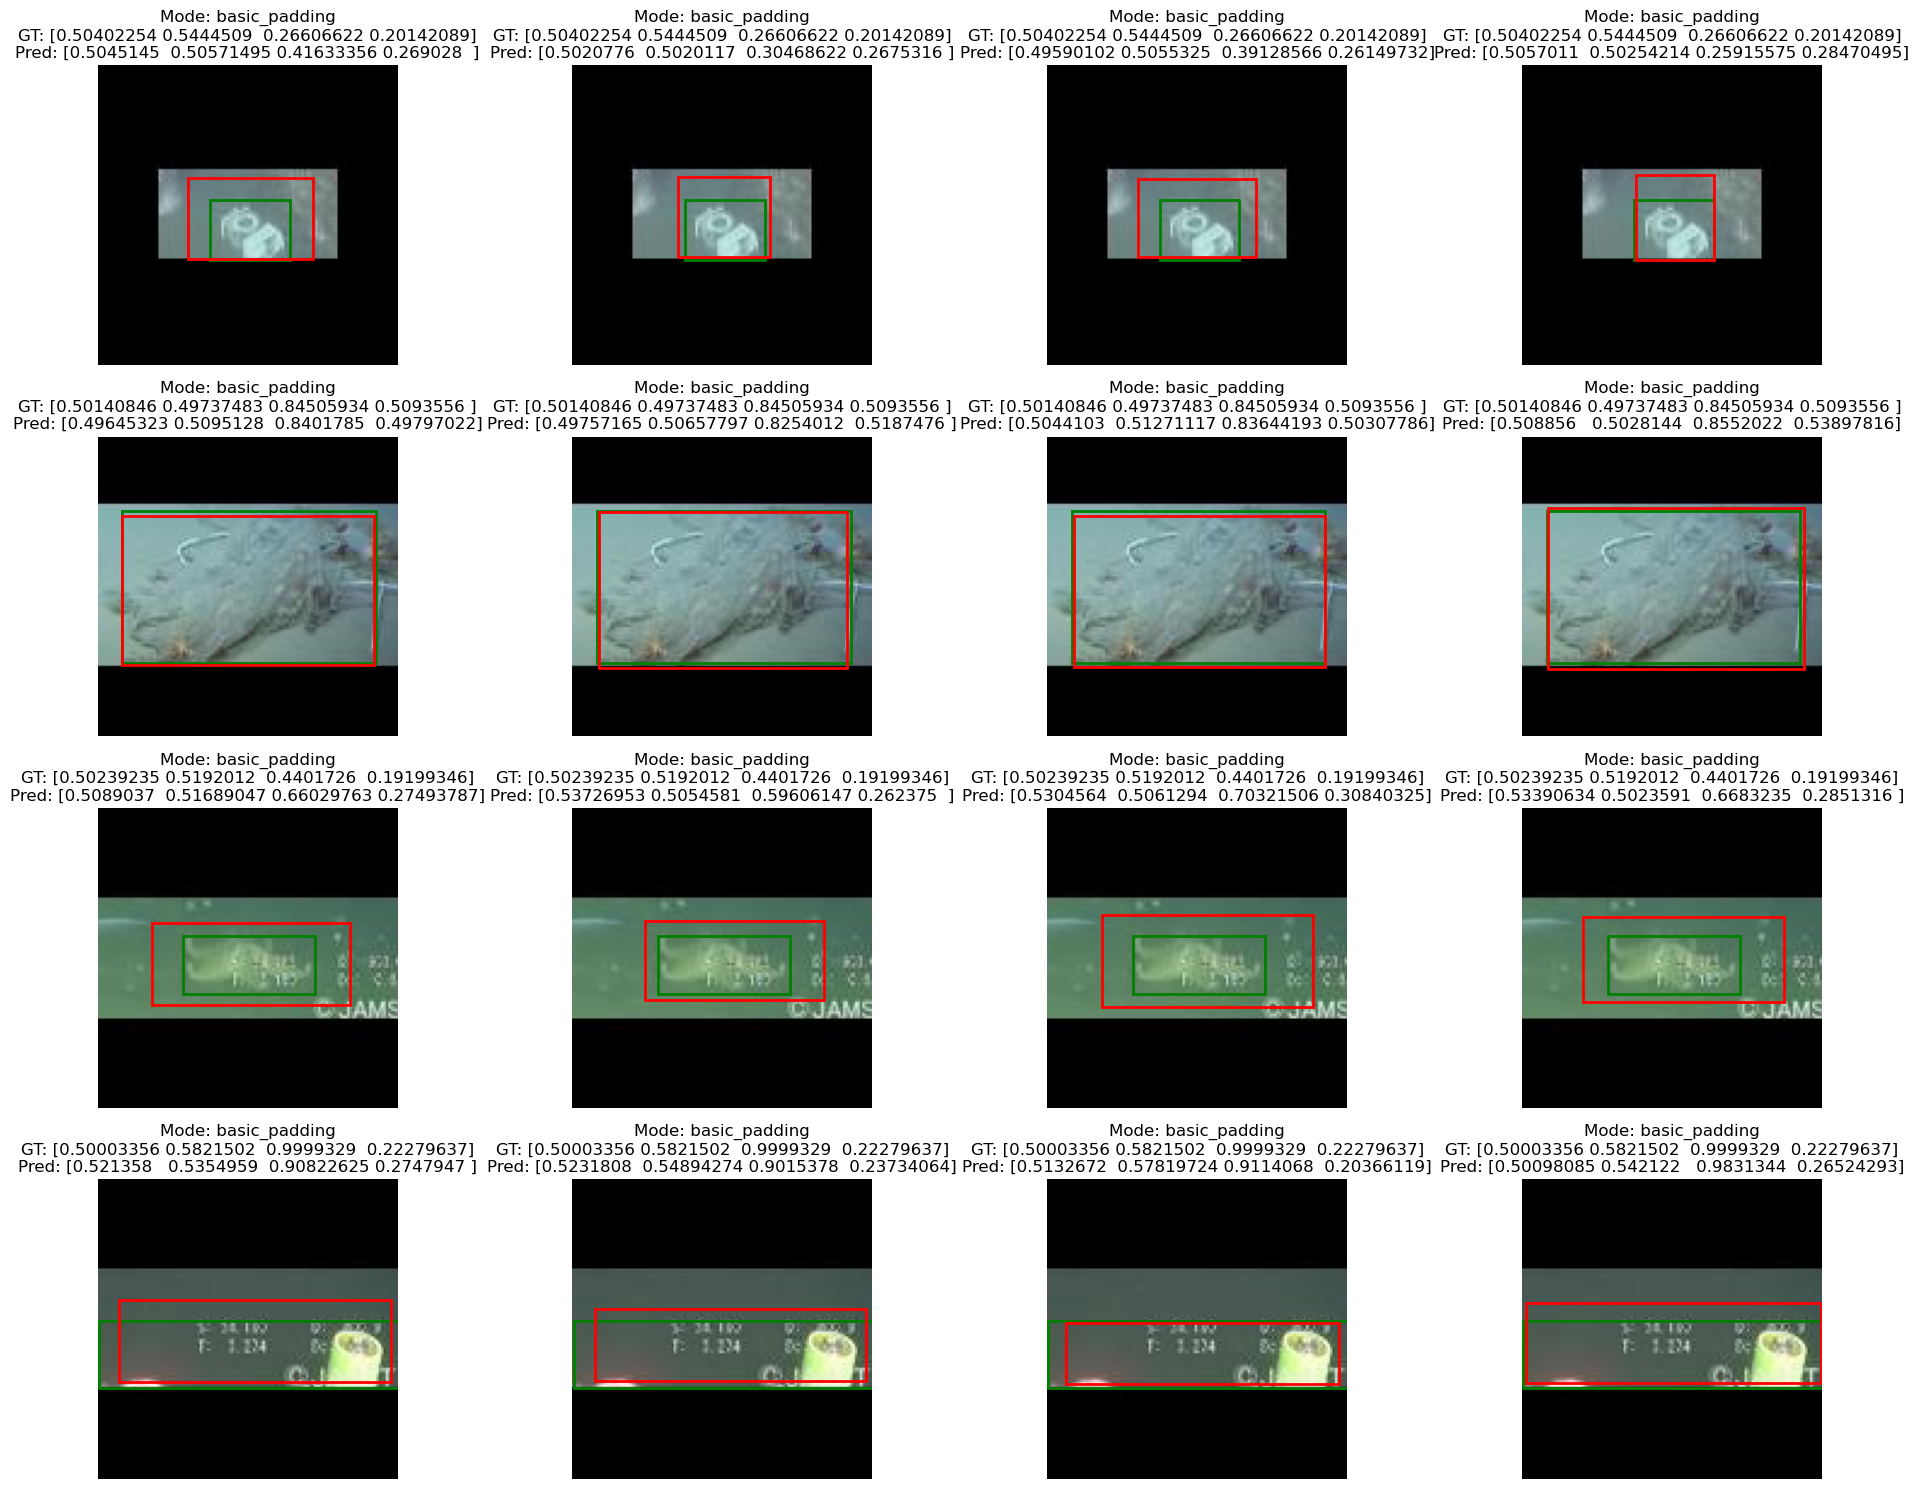

In [3]:
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataset import CroppedImageDataset
import torchvision.transforms.functional as F
from FocusNet import FocusNet
from FocusNetv2 import FocusNetv2
from FocusNetv3 import FocusNetv3
from FocusNetv4 import FocusNetv4
import os
from torchvision import transforms

# Model paths and modes
model_info = [
    {"path": "FocusNet_Mbasic_padding_LL1+IOU_OSGD_LR0.065_E150.pth", "mode": "basic_padding", "model": "FocusNet"},
    {"path": "FocusNetv2_Mbasic_padding_LL1+IOU_OSGD_LR0.065_E150.pth", "mode": "basic_padding", "model": "FocusNetv2"},
    {"path": "FocusNetv3_Mbasic_padding_LL1+IOU_OSGD_LR0.065_E150.pth", "mode": "basic_padding", "model": "FocusNetv3"},
    {"path": "FocusNetv4_Mbasic_padding_LL1+IOU_OSGD_LR0.065_E150.pth", "mode": "basic_padding", "model": "FocusNetv4"},
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models and datasets
models = []
datasets = []

def load_model(model_path, model_name):
    if model_name == "FocusNet":
        model = FocusNet()
    elif model_name == "FocusNetv2":
        model = FocusNetv2()
    elif model_name == "FocusNetv3":
        model = FocusNetv3()
    elif model_name == "FocusNetv4":
        model = FocusNetv4()
    else:
        raise ValueError("Invalid model name.")
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

transform = transforms.Compose([transforms.ToTensor()])

for info in model_info:
    models.append(load_model(info["path"], info["model"]))
    datasets.append(CroppedImageDataset(mode=info["mode"], split="test", transform=transform))

print("All models and datasets loaded successfully.")

def scale_bbox(bbox, image_size):
    """Scale bounding box for visualization."""
    cx, cy, w, h = bbox
    xmin = (cx - w / 2) * image_size
    ymin = (cy - h / 2) * image_size
    xmax = (cx + w / 2) * image_size
    ymax = (cy + h / 2) * image_size
    return xmin, ymin, xmax, ymax

def evaluate_and_display(models, datasets, num_images=4, save_dir="visualizations"):
    """
    Evaluate and display predictions for all models on the same images.
    Displays results in a 4x4 grid.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create directory for visualizations if it doesn't exist

    # Randomly select images
    selected_indices = random.sample(range(len(datasets[0])), num_images)

    # Create a matplotlib grid for displaying the images
    fig, axes = plt.subplots(num_images, len(model_info), figsize=(20, 15))

    for row_idx, idx in enumerate(selected_indices):
        for col_idx, (model, dataset) in enumerate(zip(models, datasets)):
            # Get image and ground-truth bbox
            image, gt_bbox, _ = dataset[idx]
            gt_bbox = gt_bbox.numpy()

            # Predict bbox
            image_input = image.unsqueeze(0).to(device)  # Add batch dimension
            with torch.no_grad():
                pred_bbox = model(image_input).squeeze(0).cpu().numpy()

            # Scale bboxes for visualization
            image_size = 124
            gt_xmin, gt_ymin, gt_xmax, gt_ymax = scale_bbox(gt_bbox, image_size)
            pred_xmin, pred_ymin, pred_xmax, pred_ymax = scale_bbox(pred_bbox, image_size)

            # Convert image tensor to PIL for visualization
            pil_image = F.to_pil_image(image)

            # Create the plot
            ax = axes[row_idx, col_idx]
            ax.imshow(pil_image)

            # Ground truth bbox
            ax.add_patch(plt.Rectangle(
                (gt_xmin, gt_ymin), gt_xmax - gt_xmin, gt_ymax - gt_ymin,
                fill=False, edgecolor='green', linewidth=2, label="Ground Truth"
            ))

            # Predicted bbox
            ax.add_patch(plt.Rectangle(
                (pred_xmin, pred_ymin), pred_xmax - pred_xmin, pred_ymax - pred_ymin,
                fill=False, edgecolor='red', linewidth=2, label="Prediction"
            ))

            ax.set_title(f"Mode: {model_info[col_idx]['mode']}\nGT: {gt_bbox}\nPred: {pred_bbox}")
            ax.axis("off")

    # Adjust layout and display the grid
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "comparison_grid.png"))
    plt.show()

# Evaluate and display
evaluate_and_display(models, datasets, num_images=4)